## Quark-Gluon Dataset Compression ## 
This creates a new smaller QG dataset of 3x3 pixel images.

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import h5py

In [30]:
f = h5py.File("../data/quark-gluon_train-set_n793900.hdf5", "r")

In [2]:
x_train = f.get('X_jets')
y_train = f.get('y')

NameError: name 'f' is not defined

In [32]:
size = 16
Nvals = 2
Nsamples = 100000
QG_channel = 1
file_name = f"../data/QG{QG_channel}_normalized_16x16_100k"

In [33]:
def discretize_img(img):
    bins = np.linspace(0,1,Nvals+1)
    vals = np.linspace(0,1,Nvals)
    inds = np.digitize(img, bins)
    return vals[inds-1]

def crop_and_resize(x, channel, scale, crop_fraction=0.8):
    crop_size = int(125 * crop_fraction)
    start = (125 - crop_size) // 2
    end = start + crop_size
    channel_data = x[:, :, :, channel]
    cropped = channel_data[:, start:end, start:end]
    
    resized = np.zeros((x.shape[0], scale, scale), dtype=channel_data.dtype)
    for i in range(x.shape[0]):
        resized[i] = np.array(
            [[cropped[i, int(y * crop_size / scale), int(x * crop_size / scale)] 
              for x in range(scale)] 
             for y in range(scale)]
        )
    
    return resized[..., np.newaxis]

In [34]:
channel = 2
batch_size = 200
num_batches = Nsamples//batch_size

events = Nsamples

fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,size,size), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')

for i in range(num_batches):
    x = x_train[i * batch_size: (i + 1) * batch_size]
    y = y_train[i * batch_size: (i + 1) * batch_size]

    x_train_small = crop_and_resize(x, channel, size, crop_fraction=0.7)
    print(x_train_small)

    div1 = np.max(x_train_small, axis=(1,2)).reshape((batch_size,1,1,1))
    div1[div1 == 0] = 1
    x_train_small = x_train_small / (div1+0.00001)

    x_discr = discretize_img(x_train_small)

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_discr.reshape((x_discr.shape[0], size, size))
    print("batch ",i,"/",num_batches, end="\r")


[[[[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [9.9901998e-05]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [3.4307613e-04]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0

In [35]:
fnew.close()

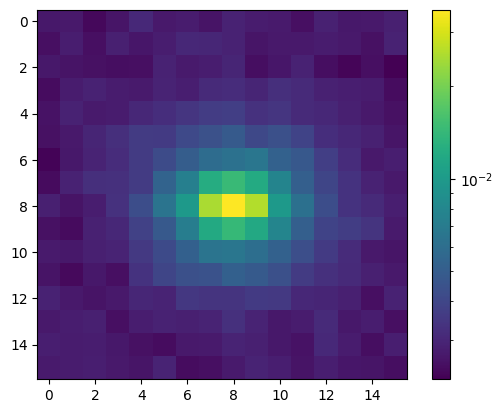

In [33]:
ftest = h5py.File(file_name,"r")

plt.imshow(np.mean(ftest['X'], axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [5]:
div1 = np.max(x_train[:30,:,:,1], axis=(1,2)).reshape((30,1,1))
div1[div1 == 0] = 1

plt.imshow(np.mean(x_train[:30,:,:,1]/div1+0.0000001,axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

NameError: name 'x_train' is not defined

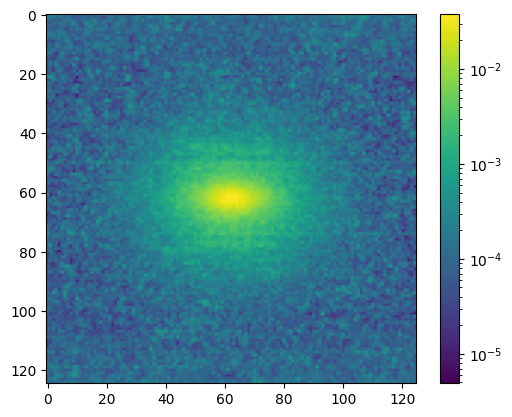

In [38]:
div1 = np.max(x_train[:3000,:,:,1], axis=(1,2)).reshape((3000,1,1))
div1[div1 == 0] = 1

plt.imshow(np.mean(x_train[:3000,:,:,1]/div1+0.0000001,axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

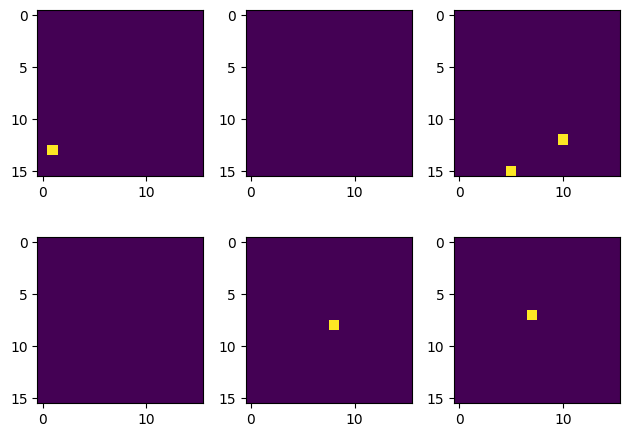

In [34]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,Nsamples,size=(16,))
ax[0,0].imshow(ftest['X'][nums[0]])
ax[0,1].imshow(ftest['X'][nums[1]])
ax[0,2].imshow(ftest['X'][nums[2]])
ax[1,0].imshow(ftest['X'][nums[3]])
ax[1,1].imshow(ftest['X'][nums[4]])
ax[1,2].imshow(ftest['X'][nums[5]])
fig.tight_layout()

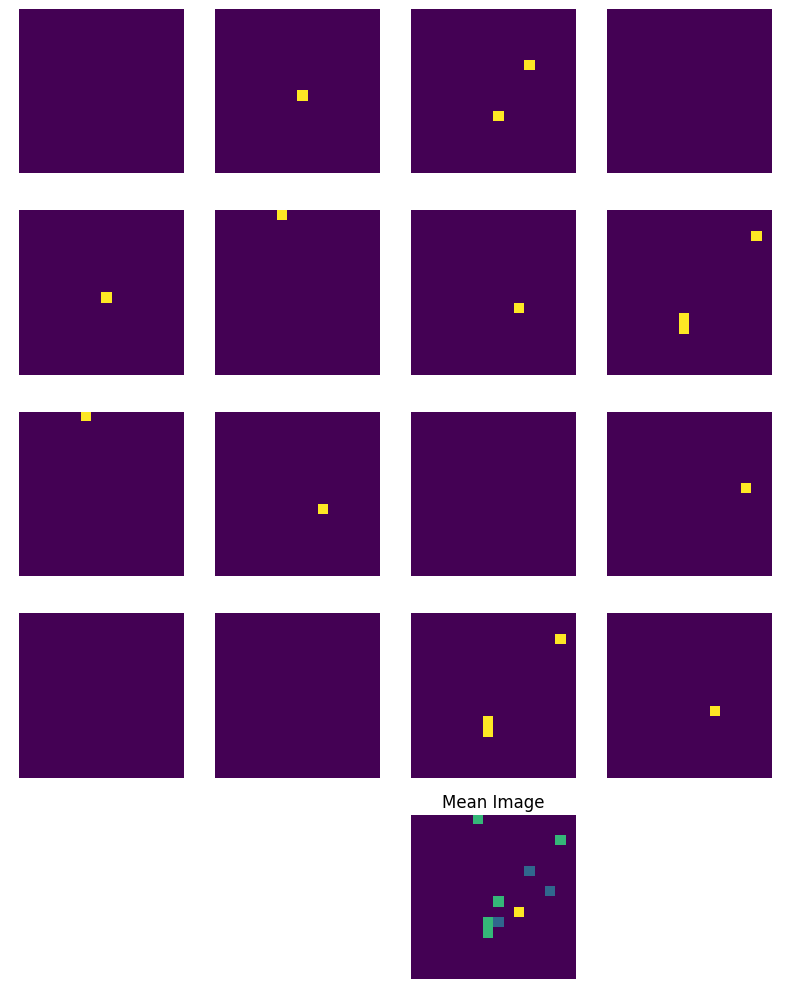

In [36]:
def plot_many_samples_with_mean(data, Nsamples, num_rows=4, num_cols=4):
    total_images = num_rows * num_cols
    fig, ax = plt.subplots(num_rows + 1, num_cols, figsize=(num_cols * 2, (num_rows + 1) * 2))
    
    nums = np.random.randint(0, Nsamples, size=(total_images,))
    
    selected_images = []
    
    for i in range(num_rows):
        for j in range(num_cols):
            sample_idx = nums[i * num_cols + j]
            selected_image = data[sample_idx]
            selected_images.append(selected_image)
            ax[i, j].imshow(selected_image, cmap='viridis')
            ax[i, j].axis('off') 

    mean_image = np.mean(np.array(selected_images), axis=0)
    
    for j in range(num_cols):
        if j == num_cols // 2:
            ax[num_rows, j].imshow(mean_image, cmap='viridis')
            ax[num_rows, j].set_title("Mean Image", fontsize=12)
            ax[num_rows, j].axis('off')
        else:
            ax[num_rows, j].axis('off')
    
    fig.tight_layout()
    plt.show()

plot_many_samples_with_mean(ftest['X'], Nsamples=16, num_rows=4, num_cols=4)


In [40]:
ftest.close()